In [104]:
%config Completer.use_jedi = False
import scanpy as sc
import pandas as pd
sc.set_figure_params(dpi = 120)
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt

# create a color dictionary for tissues
def tissue_colors():
    
    tissue_color_dict = {'Bladder': '#e7969c',
             'Blood': '#d6616b',
             'Bone_Marrow': '#cedb9c',
             'Eye': '#c7ea46',#"#00ff7f",
             'Fat': '#e7cb94',
             'Heart': '#ff0800',
             'Kidney': '#7b4173',
             'Large_Intestine': '#31a354',
             'Liver': '#000080',
             'Lung': '#3182bd',
             'Lymph_Node': '#8c6d31',
             'Mammary':'#ce6dbd',
             'Muscle': '#e7ba52',
             'Pancreas': '#fd8d3c',
             'Prostate':'#637939',#'#a55194',#
             'Salivary_Gland':'#622a0f',
             'Skin': '#de9ed6',
             'Small_Intestine': '#6baed6',
             'Spleen': '#393b79',
             'Thymus': '#9c9ede',
             'Tongue':'#b5cf6b',
             'Trachea': '#969696',
             'Uterus':'#c64b8c',#'#ff0090',
             'Vasculature': '#843c39'}
    
    return tissue_color_dict


IGHG_genes = ['IGHG1', 'IGHG2', "IGHG3", "IGHG4"]
IGHA_genes = ['IGHA1', 'IGHA2']
IGHMD_genes = ["IGHM", "IGHD"]
IGH_genes = ['IGHM', 'IGHD', "IGHE"] + IGHA_genes + IGHG_genes


params = {
    'font.size': 7,
    'axes.titlesize': 7,
    'axes.labelsize': 7,
    'legend.fontsize': 7,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'font.family': "Helvetica",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 150
   }

mpl.rcParams.update(params)

sns.set_style("ticks")

savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0, "transparent": True}
mpl.rc('savefig', dpi=300)
output_dir = "../../figures/"
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir  + name + output_suffix + output_format, **savefig_args)
    return None

In [7]:
cell_label = 'cell_ontology_class'
# cannot currently read this object because it kills my kernel
adata = sc.read_h5ad('../../data/TSP1_TSP15_scvi_donor-method_normalized-log1p-scaled_annotated.h5ad', backed='r+')

adata = adata[adata.obs.cell_ontology_class.str.contains('b cell|plasma cell')]

adata = adata.to_memory()


In [8]:
adata = adata[~adata.obs.cell_ontology_class.str.contains('club')]
adata = adata[~adata.obs.cell_ontology_class.str.contains('doublet')]


In [99]:
print(adata.obs.cell_ontology_class.value_counts())

b cell                   19884
memory b cell            15749
plasma cell              11593
naive b cell              6818
b cell, cd19-positive        1
Name: cell_ontology_class, dtype: int64


In [10]:
def _pp(adata, log, normalize, remove_dissociation):
    if normalize:
        sc.pp.normalize_total(adata)
    if log:
        sc.pp.log1p(adata, chunk_size=50000)
    adata.raw = adata 
   
    if remove_dissociation:
    #mouse2human = pd.read_csv('../metadata/mouse2human.csv')
        dissociation_genes = pd.read_csv('../metadata/Mouse2Human_dissociation_genes.csv')
        adata.var['not_dissociation_gene'] = ~adata.var.index.isin(dissociation_genes['Human gene name'])
        adata = adata[:, adata.var.not_dissociation_gene == True]
    return adata

In [11]:
adata = _pp(adata, True, True, False)

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [12]:


sc.tl.score_genes(adata
                  , gene_list=IGHG_genes, 
                  score_name='IgG_Score')
sc.tl.score_genes(adata, gene_list=IGHA_genes, 
                  
                  score_name='IgA_Score')
sc.tl.score_genes(adata, gene_list=IGHMD_genes, 
                 
                  score_name='IgMD_Score')
sc.tl.score_genes(adata, gene_list=['IGHE'], 
                 
                  score_name='IgE_Score')



In [13]:
plotdf = sc.get.obs_df(
                adata,
                keys=['IGHD', 'IGHG1', "IGHG2", 'IGHG4', 'IGHG3', 'IGHA1', "IGHA2", "IGHM", 'IGHE', 'tissue', 
                      'IgG_Score', 'IgA_Score', 'IgMD_Score', 'cell_ontology_class'])

In [14]:
# Shameless hacked from scanpy
scores = adata.obs[['IgG_Score', 'IgA_Score', 'IgMD_Score']]
isotype = pd.Series('IgM/D', index=scores.index)

# if G2M is higher than S, it's G2M
isotype[(scores.IgG_Score > scores.IgMD_Score) & (scores.IgG_Score > scores.IgA_Score)] = 'IgG'
isotype[(scores.IgA_Score > scores.IgMD_Score) & (scores.IgA_Score > scores.IgG_Score)] = 'IgA'
# if all scores are negative, it's IGHE... not sure this applies here 
#phase[np.all(scores < 0, axis=1)] = 'IGHE'

adata.obs['Isotype'] = isotype

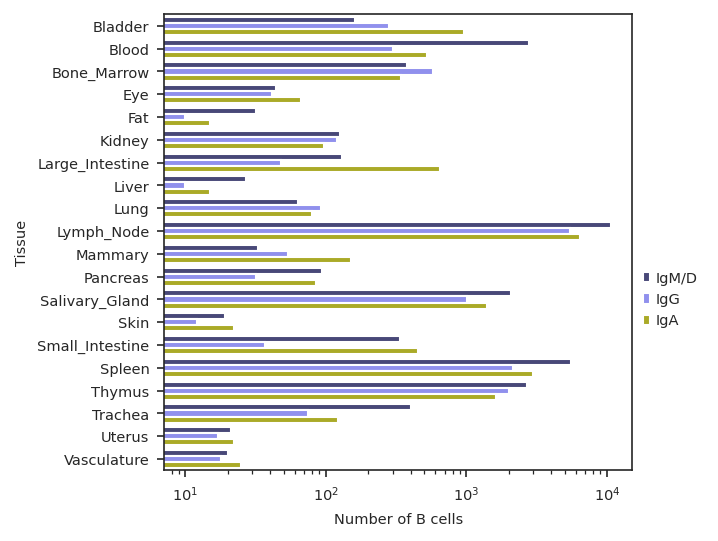

In [105]:
fig, ax = plt.subplots(1,1)

sns.countplot(data = adata.obs, y = 'tissue', hue = 'Isotype', palette='gist_stern')
plt.ylabel('Tissue')
plt.xlabel('Number of B cells')
plt.xscale('log')
ax.legend(loc='lower left', bbox_to_anchor= (1.01, 0.3), ncol=1,
            borderaxespad=0, frameon=False)

save_figure(fig, name = 'IsotypeCellCounts')

# Fraction of B Cells

In [106]:
b_cell_counts = adata.obs.groupby(['tissue']).count()["Isotype"]

In [107]:
P = adata.obs.groupby(['tissue'])['Isotype'].value_counts(normalize = True)
P = pd.DataFrame(P)
P.columns = ['Isotype Fraction']
P.reset_index(inplace=True)

# Sort by IgA relative abundance
IgA = P[P.Isotype == 'IgA']
IgA.sort_values('Isotype Fraction', inplace=True, ascending=False)

<ipython-input-107-3e124d2e7bc8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IgA.sort_values('Isotype Fraction', inplace=True, ascending=False)


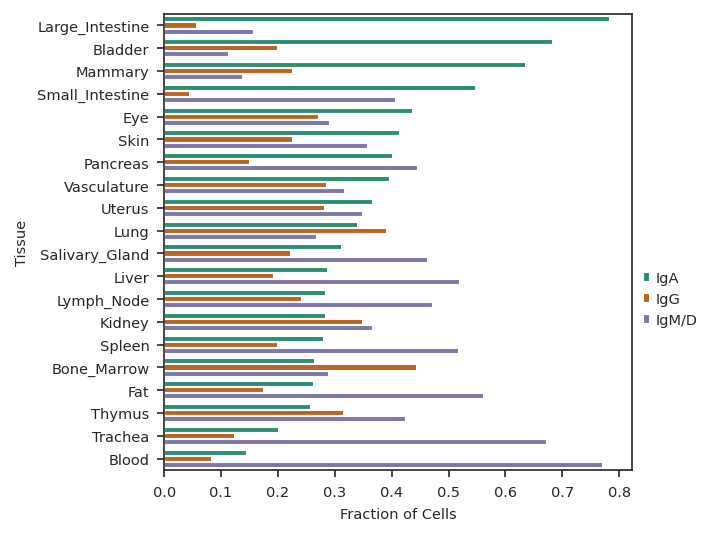

In [126]:
cm = 1/2.54
fig, ax = plt.subplots(1,1)

sns.barplot(data = P, x = 'Isotype Fraction', y = 'tissue', hue = 'Isotype', palette='Dark2', order= IgA.tissue)

plt.ylabel('Tissue')
plt.xlabel('Fraction of Cells')
ax.legend(loc='lower left', bbox_to_anchor= (1.01, 0.3), ncol=1,
            borderaxespad=0, frameon=False)


save_figure(fig, name = 'IsotypeCellFraction')

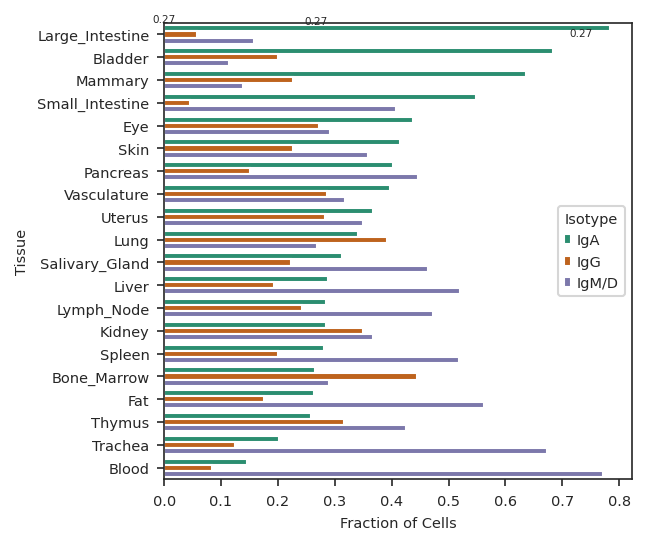

In [124]:
cm = 1/2.54
plt.plot(0,1)
plots = sns.barplot(data = P, x = 'Isotype Fraction', y = 'tissue', hue = 'Isotype', palette='Dark2', order= IgA.tissue)

plt.ylabel('Tissue')
plt.xlabel('Fraction of Cells')
ax.legend(loc='lower left', bbox_to_anchor= (1.01, 0.3), ncol=1,
            borderaxespad=0, frameon=False)


save_figure(fig, name = 'IsotypeCellFraction')

In [118]:
plots

<AxesSubplot:xlabel='Fraction of Cells', ylabel='Tissue'>

In [114]:
for patch in fig.patches:
    print(patch)

In [110]:
pd.merge(IgA, b_cell_counts, left_on='tissue', right_index=True)['Isotype_y']

18      827
0      1394
30      239
42      822
9       151
39       53
34      211
57       63
54       60
25      235
37     4481
22       52
28    22590
17      341
46    10675
8      1295
13       57
50     6311
52      600
4      3588
Name: Isotype_y, dtype: int64

In [79]:
b_cell_counts

tissue
Bladder             1394
Blood               3588
Bone_Marrow         1295
Eye                  151
Fat                   57
Kidney               341
Large_Intestine      827
Liver                 52
Lung                 235
Lymph_Node         22590
Mammary              239
Pancreas             211
Salivary_Gland      4481
Skin                  53
Small_Intestine      822
Spleen             10675
Thymus              6311
Trachea              600
Uterus                60
Vasculature           63
Name: Isotype, dtype: int64

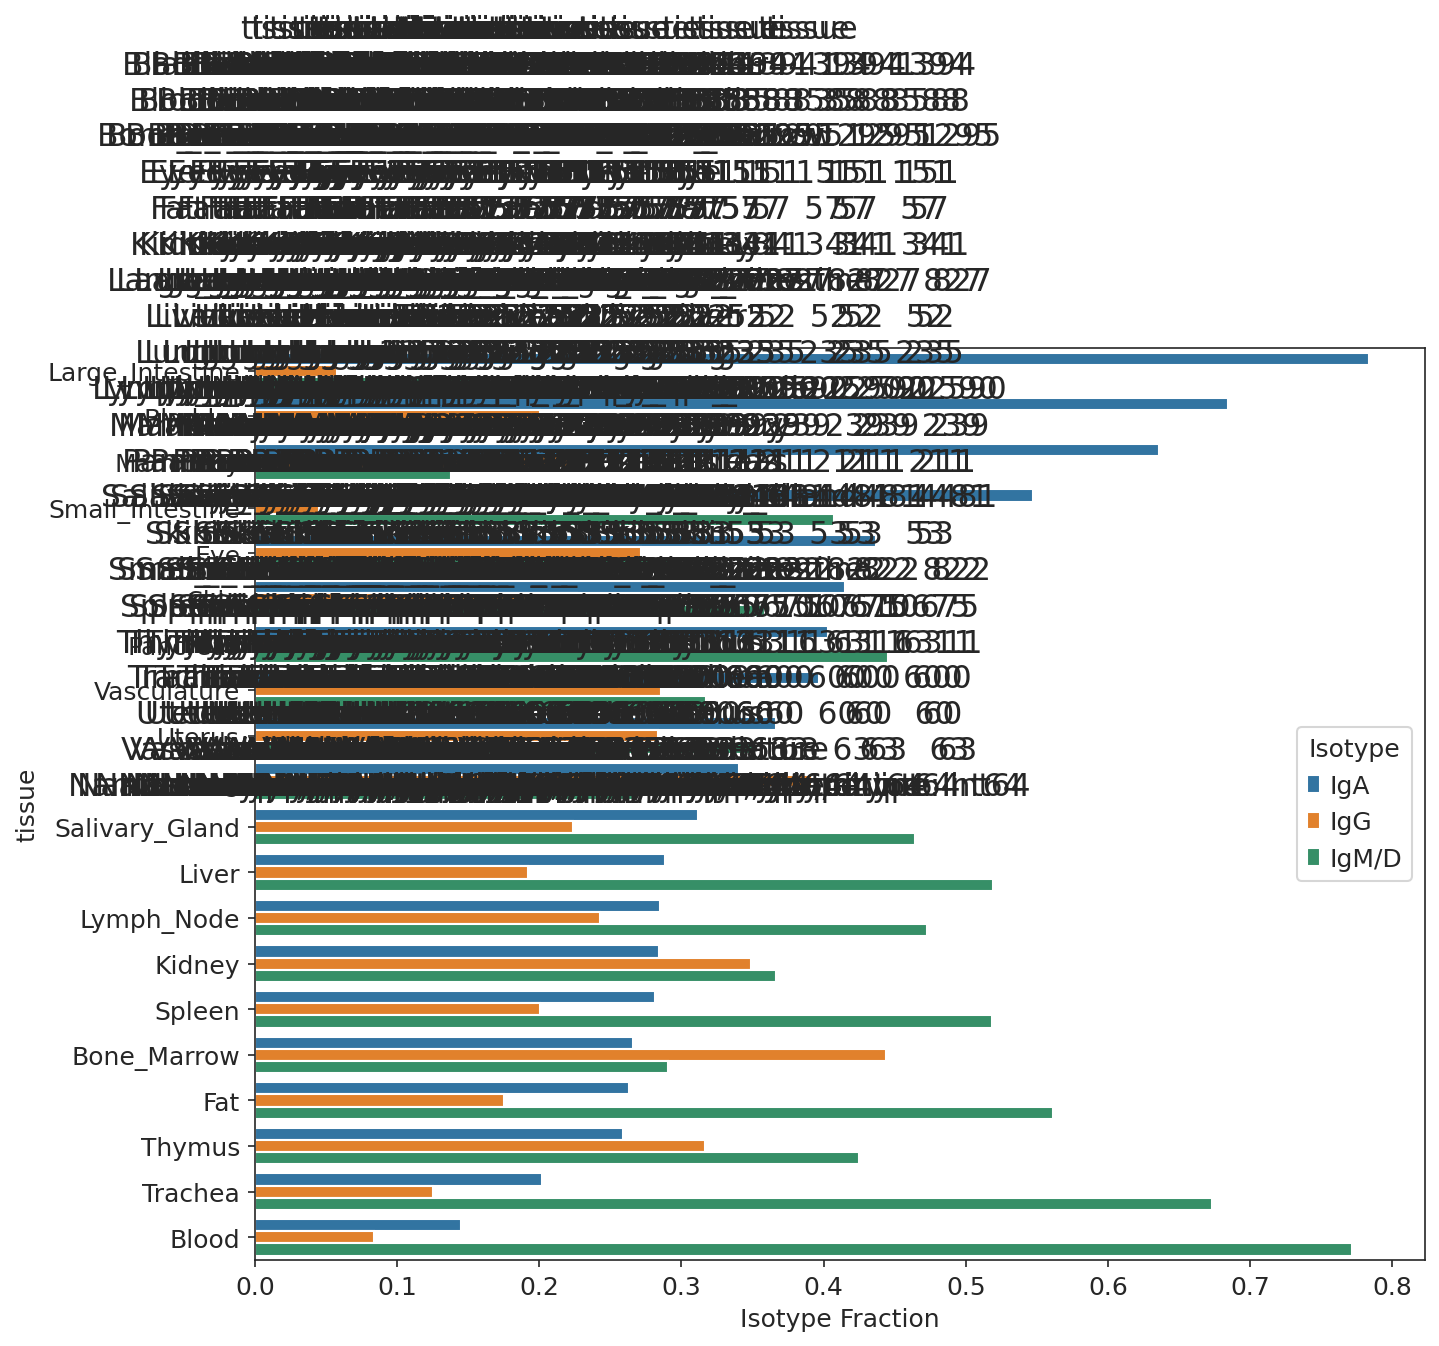

In [37]:
plt.figure(figsize=(10, 8))
splot=sns.barplot(x="Isotype Fraction", y="tissue", hue="Isotype", data=P, order= IgA.tissue)
#plt.ylabel("Mean Salary in US Dollars", size=14)
#plt.xlabel("Education", size=14)
#plt.title("Grouped Barplot: Gender Bias in Salary", size=18)
for p in splot.patches:
    splot.annotate(format(round(b_cell_counts)), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

In [ ]:
P = adata.obs.groupby(['tissue'])['cell_ontology_class'].value_counts(normalize = True)
P = pd.DataFrame(P)
P.columns = ['fraction']
P.reset_index(inplace=True)

# Sort by IgA relative abundance
pc = P[P.cell_ontology_class == 'b cell']
pc.sort_values('fraction', inplace=True, ascending=False)

In [ ]:
sns.set_palette('Set3')

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (1.5,5))
P = P[~P.cell_ontology_class.str.contains('cd19')]
sns.barplot(data = P, x = 'fraction', y = 'tissue', hue = 'cell_ontology_class', order= pc.tissue, saturation=1, )
plt.ylabel('Tissue')
plt.xlabel('Fraction of B Lineage Cells')
ax.legend(loc='lower left', bbox_to_anchor= (1.01, 0.3), ncol=1,
            borderaxespad=0, frameon=False)

save_figure(fig, name = 'CellTypeFractions')

In [ ]:
# import pandas for data wrangling
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = IgA

# initialize the figure
plt.figure(figsize=(20,10))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 1
lowerLimit = 0
labelPadding = 0.1

# Compute max and min in the dataset
max = df['Isotype Fraction'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * df['Isotype Fraction'] + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(df.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(df.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="black",
    color="#61a4b2",
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df["tissue"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 

In [ ]:
sns.barplot(IgA, x = 'tissue', y = 'Isotype Fraction')